In [8]:
# https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption

In [9]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('Steel_industry_data.csv')
df

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


In [11]:
lbl_encoder = LabelEncoder()
df['WeekStatus'] = lbl_encoder.fit_transform(df['WeekStatus'])
df['Day_of_week'] = lbl_encoder.fit_transform(df['Day_of_week'])
df['Load_Type'] = lbl_encoder.fit_transform(df['Load_Type'])

In [12]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

df['day'] = pd.to_datetime(df['date']).dt.day_of_year
df['month'] = pd.to_datetime(df['date']).dt.month
df['time'] = pd.to_datetime(df['date']).dt.time

df['day'] = pd.to_numeric(df['day'])
df['month'] = pd.to_numeric(df['month'])

df = df.drop('date', axis=1)

df

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,day,month,time
0,3.17,2.95,0.00,0.0,73.21,100.00,900,0,1,0,1,1,00:15:00
1,4.00,4.46,0.00,0.0,66.77,100.00,1800,0,1,0,1,1,00:30:00
2,3.24,3.28,0.00,0.0,70.28,100.00,2700,0,1,0,1,1,00:45:00
3,3.31,3.56,0.00,0.0,68.09,100.00,3600,0,1,0,1,1,01:00:00
4,3.82,4.50,0.00,0.0,64.72,100.00,4500,0,1,0,1,1,01:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,3.85,4.86,0.00,0.0,62.10,100.00,82800,0,1,0,365,12,23:00:00
35036,3.74,3.74,0.00,0.0,70.71,100.00,83700,0,1,0,365,12,23:15:00
35037,3.78,3.17,0.07,0.0,76.62,99.98,84600,0,1,0,365,12,23:30:00
35038,3.78,3.06,0.11,0.0,77.72,99.96,85500,0,1,0,365,12,23:45:00


In [13]:
df_train = df.sample(frac=0.8)
df_test = df.drop(df_train.index)

In [14]:
n = 1000
nu = 0.1
trees = []
PARAMS = ['Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'day', 'month']
df_train['y_pred'] = df_train['Usage_kWh'].mean()

for i in range(n):
    df_train['r'] = df_train['Usage_kWh'] - df_train['y_pred']
    tree = DecisionTreeRegressor(max_depth=5)
    tree.fit(df_train[PARAMS], df_train['r'])
    df_train['y_pred'] += nu * tree.predict(df_train[PARAMS])
    trees.append(tree)
df_train

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,day,month,time,y_pred,r
1631,36.90,27.29,0.00,0.02,80.40,100.00,0,0,6,0,17,1,00:00:00,36.941203,-0.041514
13860,58.64,31.10,0.00,0.03,88.34,100.00,33300,0,0,2,145,5,09:15:00,58.712381,-0.072692
31398,3.49,2.81,0.14,0.00,77.89,99.92,6300,1,2,0,328,11,01:45:00,3.425019,0.065217
1040,122.51,45.79,0.00,0.06,93.67,100.00,72900,0,4,2,11,1,20:15:00,122.713024,-0.203335
33648,11.12,0.86,18.65,0.01,99.70,51.21,44100,0,1,2,351,12,12:15:00,11.270860,-0.151422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14501,2.92,5.44,0.00,0.00,47.29,100.00,5400,0,0,0,152,6,01:30:00,2.933934,-0.013772
5497,3.85,3.02,0.00,0.00,78.68,100.00,23400,0,5,0,58,2,06:30:00,3.880160,-0.031184
15615,63.61,18.36,0.00,0.03,96.08,100.00,57600,0,5,1,163,6,16:00:00,63.644019,-0.034331
18287,50.65,37.55,0.18,0.02,80.33,100.00,43200,0,5,1,191,7,12:00:00,50.800672,-0.150984


In [15]:
df_test['y_pred'] = df_test['Usage_kWh'].mean()
for tree in trees:
    df_test['y_pred'] += nu * tree.predict(df_test[PARAMS])
df_test['r'] = df_test['Usage_kWh'] - df_test['y_pred']
df_test

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,day,month,time,y_pred,r
5,3.28,3.56,0.00,0.0,67.76,100.00,5400,0,1,0,1,1,01:30:00,3.035209,0.244791
14,3.31,3.85,0.00,0.0,65.19,100.00,13500,0,1,0,1,1,03:45:00,3.109941,0.200059
20,3.56,4.07,0.00,0.0,65.84,100.00,18900,0,1,0,1,1,05:15:00,3.298783,0.261217
36,3.60,0.00,16.96,0.0,100.00,20.76,33300,0,1,0,1,1,09:15:00,3.465359,0.134641
37,4.03,0.00,21.28,0.0,100.00,18.61,34200,0,1,0,1,1,09:30:00,3.813280,0.216720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35002,4.07,0.00,20.16,0.0,100.00,19.79,53100,0,1,0,365,12,14:45:00,3.792614,0.277386
35003,3.53,0.00,14.90,0.0,100.00,23.05,54000,0,1,0,365,12,15:00:00,3.261979,0.268021
35015,3.42,0.00,9.79,0.0,100.00,32.98,64800,0,1,0,365,12,18:00:00,3.478935,-0.058935
35025,3.38,0.00,13.43,0.0,100.00,24.41,73800,0,1,0,365,12,20:30:00,3.179929,0.200071


In [16]:
print(f'MAE train: {mean_absolute_error(df_train['Usage_kWh'], df_train['y_pred'])}')
print(f'MAE test: {mean_absolute_error(df_test['Usage_kWh'], df_test['y_pred'])}')

MAE train: 0.16362691287442732
MAE test: 0.4172948847241741


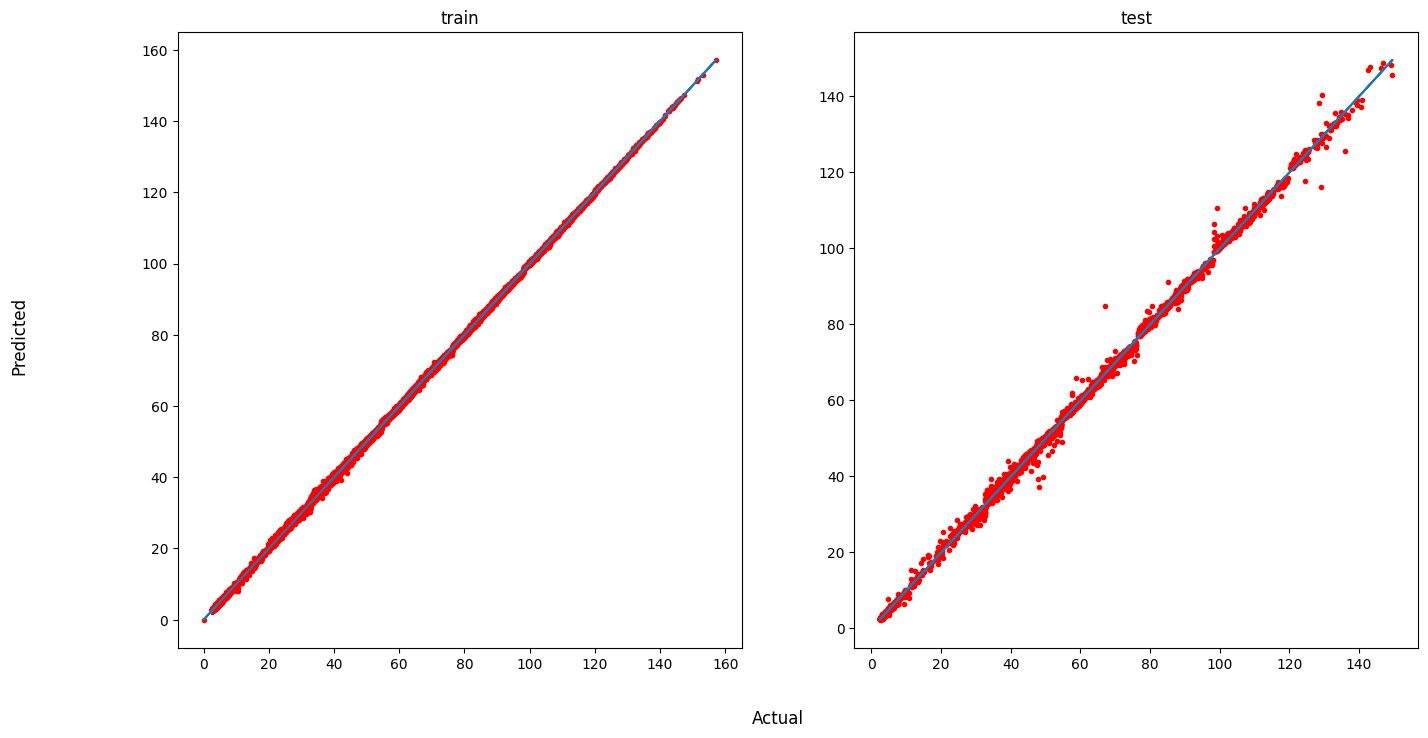

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 8)
fig.supxlabel('Actual')
fig.supylabel('Predicted')

x_train = df_train['Usage_kWh']
y_train = df_train['y_pred']

ax1.plot(x_train, y_train, '.', color = 'r')
m, b = np.polyfit(x_train, y_train, 1)
ax1.plot(x_train, m * x_train + b)
ax1.title.set_text('train')

x_test = df_test['Usage_kWh']
y_test = df_test['y_pred']

ax2.plot(x_test, y_test, '.', color = 'r')
m, b = np.polyfit(x_test, y_test, 1)
ax2.plot(x_test, m * x_test + b)
ax2.title.set_text('test')
